## 共通処理

In [1]:
# 必要なパッケージをインポート
# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

import random

In [2]:
import pymc as pm
import arviz as az

## ch6-3: IRT(Item Response Theory)によるテスト結果

In [3]:
# データ取得
df = pd.read_csv("irt-sample.csv", index_col=0)
print(df.shape)
display(df.head())

(1000, 50)


,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0


In [4]:
# データ加工
# melt関数で横持ち形式を縦持ち形式に変換
response_df = pd.melt(
    df.reset_index(), id_vars='index',
    var_name='question', value_name='response')

# 列名indexをuserに変換
response_df = response_df.rename({'index':'user'}, axis=1)

# 要素数の変化を確認
print(f'元データ(df): {df.shape}')
print(f'変換後データ(response_df): {response_df.shape}\n')

# 結果確認
display(response_df.head())

元データ(df): (1000, 50)
変換後データ(response_df): (50000, 3)



,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


In [5]:
# user_idx: response_dfのuser列を数値化した結果
# users: user_idxのインデックス値と元の文字列の対応
user_idx, users = pd.factorize(response_df['user'])

# question_idx: response_dfのquestion列を数値化した結果
# questions: question_idxのインデックス値と元の文字列の対応
question_idx, questions = pd.factorize(response_df['question'])

# response: 一次元化された観測値の配列
response = response_df['response'].values

# 結果確認
print('--- USER ---')
print(user_idx, len(user_idx))
print(users)
print('\n--- QUESTION ---')
print(question_idx, len(question_idx))
print(questions)
print('\n--- RESPONSE ---')
print(response, len(response))
     

--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)

--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')

--- RESPONSE ---
[0 1 1 ... 1 1 1] 50000


In [6]:
users[user_idx]

Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=50000)

In [7]:
questions[question_idx]

Index(['Q001', 'Q001', 'Q001', 'Q001', 'Q001', 'Q001', 'Q001', 'Q001', 'Q001',
       'Q001',
       ...
       'Q050', 'Q050', 'Q050', 'Q050', 'Q050', 'Q050', 'Q050', 'Q050', 'Q050',
       'Q050'],
      dtype='object', length=50000)

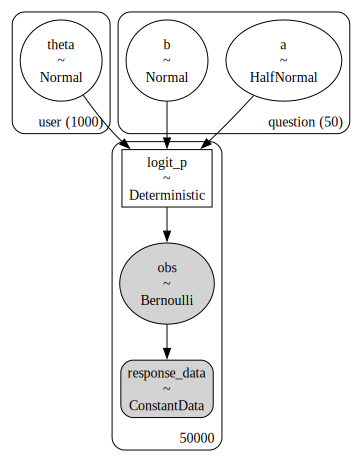

In [8]:
# 推論したいパラメータを持つ変数の配列の項目の定義
coords = {"user":users, "question":questions}

# 確率モデルを定義
model = pm.Model(coords = coords)
with model:
    
    response_data = pm.ConstantData("response_data", response)

    # 能力値
    theta = pm.Normal("theta", mu=0, sigma=1.0, dims="user")

    # 識別力
    a = pm.HalfNormal("a", sigma=1.0, dims="question")

    # 困難度
    b = pm.Normal("b", mu=0, sigma=1.0, dims="question")

    # 問題の正解確率　logit_p: 2PLM
    logit_p = pm.Deterministic("logit_p", 
                              a[question_idx] * (theta[user_idx] - b[question_idx]))
    
    # 正答したかどうか: ベルヌーイ分布
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

g = pm.model_to_graphviz(model)
display(g)

In [9]:
%time

with model:
    idata = pm.sample(chains=2,
                      tune=1000,
                      draws=1000,
                      random_seed=42
                      )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10.3 µs


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 707 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


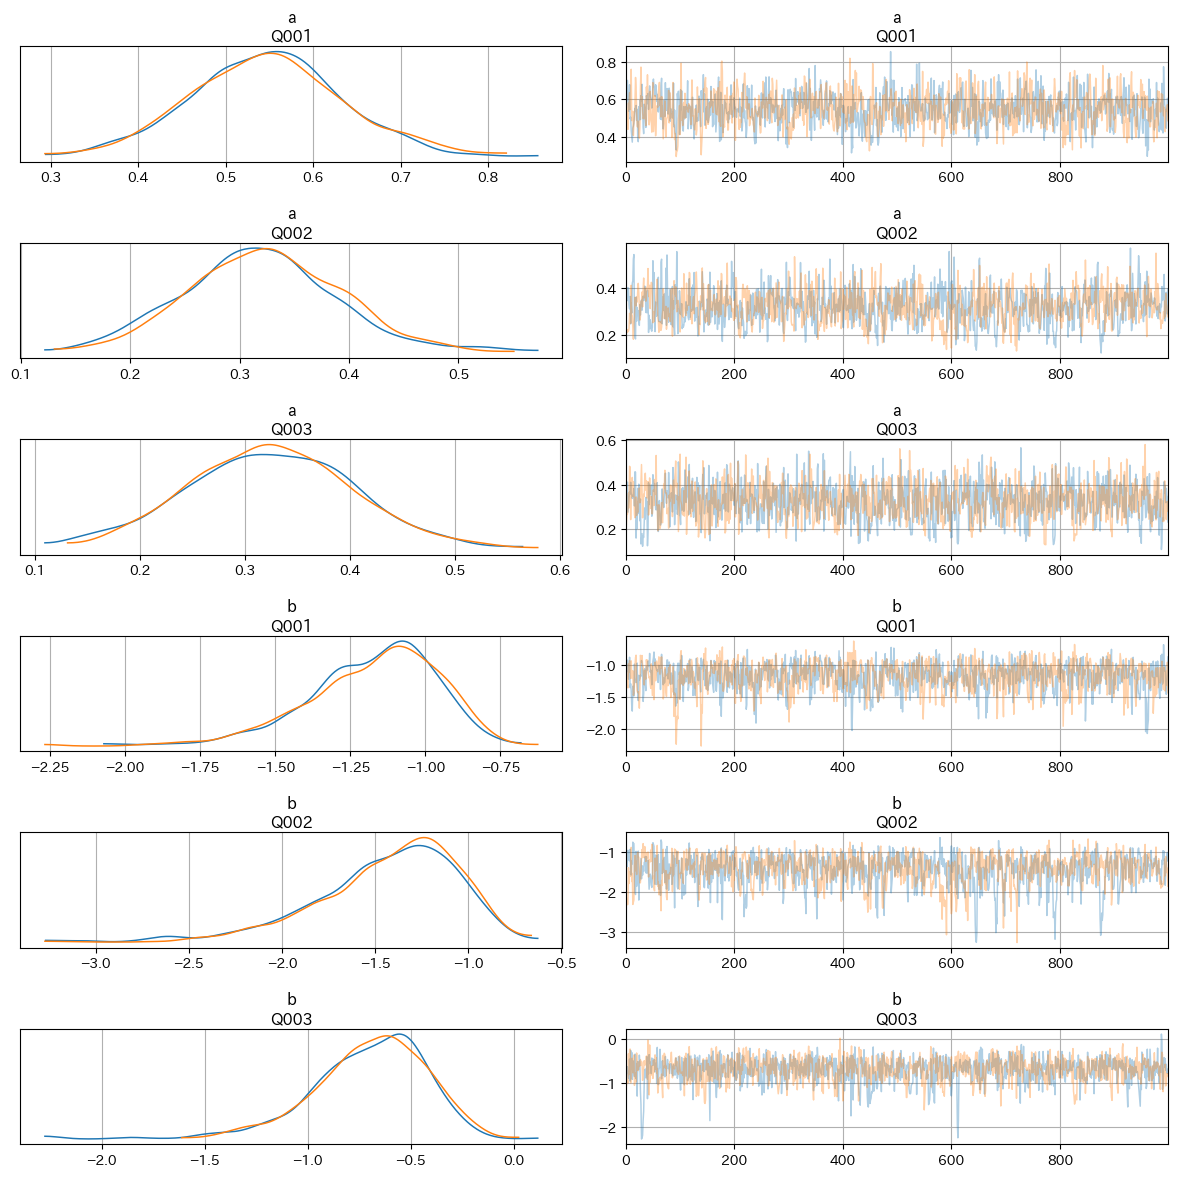

In [12]:
# Q1, Q2, Q3のパラメータ分布の描画
coords_q = {"question":['Q001', 'Q002', 'Q003']}

az.plot_trace(idata, var_names=["a", "b"], coords=coords_q, compact=False)
plt.tight_layout();

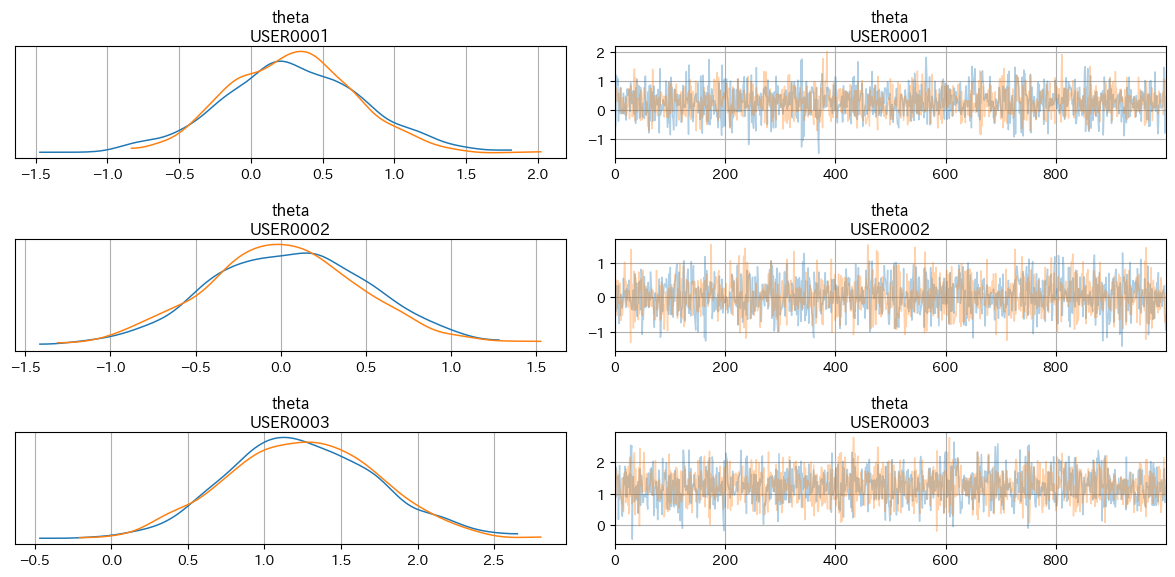

In [14]:
# 受験者1, 2, 3のパラメータ分布の推定
coords_u = {"user":['USER0001', 'USER0002', 'USER0003']}

az.plot_trace(idata, var_names=["theta"], coords=coords_u, compact=False)
plt.tight_layout();

In [16]:
a_res = az.summary(idata, var_names=["a"])
b_res = az.summary(idata, var_names=["b"])
theta_res = az.summary(idata, var_names=["theta"])

display(a_res.head())
display(b_res.head())
display(theta_res.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[Q001],0.547,0.086,0.396,0.722,0.003,0.002,860.000,913.000,1.000
a[Q002],0.321,0.071,0.181,0.451,0.002,0.002,799.000,793.000,1.000
a[Q003],0.324,0.079,0.163,0.463,0.003,0.002,964.000,856.000,1.000
a[Q004],0.688,0.093,0.514,0.857,0.003,0.002,865.000,929.000,1.000
a[Q005],0.751,0.104,0.553,0.943,0.004,0.003,812.000,999.000,1.010


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Q001],-1.174,0.217,-1.597,-0.819,0.008,0.005,906.000,1017.000,1.000
b[Q002],-1.437,0.390,-2.204,-0.855,0.015,0.011,804.000,684.000,1.000
b[Q003],-0.699,0.278,-1.205,-0.202,0.009,0.007,1092.000,852.000,1.000
b[Q004],-1.801,0.249,-2.268,-1.371,0.009,0.006,841.000,952.000,1.000
b[Q005],-2.347,0.298,-2.925,-1.842,0.011,0.008,786.000,778.000,1.010


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0001],0.291,0.467,-0.501,1.243,0.011,0.010,1969.000,1197.000,1.000
theta[USER0002],0.035,0.474,-0.884,0.906,0.010,0.011,2050.000,1585.000,1.000
theta[USER0003],1.248,0.487,0.347,2.162,0.011,0.008,1989.000,1368.000,1.000
theta[USER0004],-0.757,0.469,-1.583,0.157,0.011,0.008,1846.000,1322.000,1.000
theta[USER0005],-0.551,0.451,-1.423,0.266,0.011,0.009,1838.000,1575.000,1.000


In [17]:
summary_theta1 = az.summary(idata, var_names=['theta'])
display(summary_theta1.head())

# 受験者ごとの正答率*100を計算し「素点」とする
df_sum1 = pd.DataFrame((df.mean(axis=1)*100), columns=['素点'])

# 素点を別変数にコピー
X = df_sum1.copy()

# 素点を偏差値のスケールに補正
X_mean, X_std = X.mean(), X.std()
X = (X-X_mean)/X_std * 10 + 50
df_sum1['偏差値'] = X

# 受験者ごとの能力値の平均を抽出
x1 = summary_theta1['mean']

# 能力値を偏差値と同じスケールに補正
x1_mean, x1_std = x1.mean(), x1.std()
x1 = (x1-x1_mean)/x1_std * 10 + 50
df_sum1['能力値'] = x1.values

# 結果の確認
display(df_sum1.head(10))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0001],0.291,0.467,-0.501,1.243,0.011,0.010,1969.000,1197.000,1.000
theta[USER0002],0.035,0.474,-0.884,0.906,0.010,0.011,2050.000,1585.000,1.000
theta[USER0003],1.248,0.487,0.347,2.162,0.011,0.008,1989.000,1368.000,1.000
theta[USER0004],-0.757,0.469,-1.583,0.157,0.011,0.008,1846.000,1322.000,1.000
theta[USER0005],-0.551,0.451,-1.423,0.266,0.011,0.009,1838.000,1575.000,1.000


,素点,偏差値,能力値
USER0001,64.000,53.307,52.983
USER0002,58.000,48.449,49.901
USER0003,78.000,64.642,64.508
USER0004,48.000,40.352,40.363
USER0005,50.000,41.971,42.844
USER0006,62.000,51.687,49.106
USER0007,52.000,43.591,41.700
USER0008,54.000,45.210,44.566
USER0009,60.000,50.068,49.274
USER0010,62.000,51.687,49.274


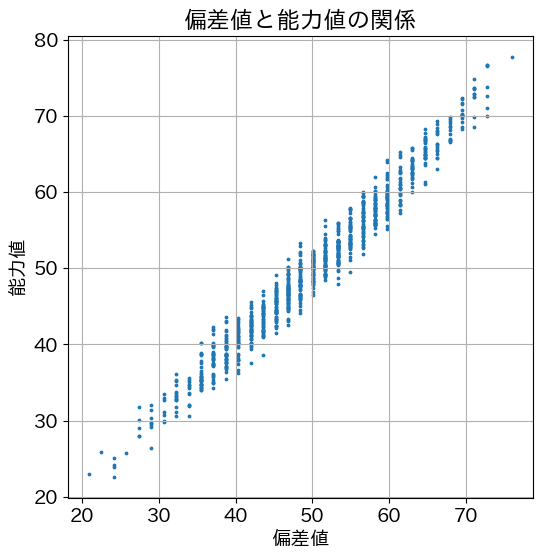

In [18]:
plt.scatter(df_sum1['偏差値'], df_sum1['能力値'], s=3)
plt.title('偏差値と能力値の関係')
plt.xlabel('偏差値')
plt.ylabel('能力値');

In [19]:

# 1. 素点62点(偏差値51.69)の受験者を抽出
df_62_1 = df_sum1.query('素点==62')
print(f'素点62点の受験者数: {len(df_62_1)}\n')

# 2. 一番能力値の低い受験者を抽出
argmin1 = df_62_1['能力値'].values.argmin()
print('素点62点で一番能力値の低い受験者\n', df_62_1.iloc[argmin1], '\n')

# 3. 一番能力値の高い受験者を抽出
argmax1 = df_62_1['能力値'].values.argmax()
print('素点62点で一番能力値の高い受験者\n', df_62_1.iloc[argmax1])

素点62点の受験者数: 59

素点62点で一番能力値の低い受験者
 素点    62.000
偏差値   51.687
能力値   48.419
Name: USER0463, dtype: float64 

素点62点で一番能力値の高い受験者
 素点    62.000
偏差値   51.687
能力値   56.367
Name: USER0064, dtype: float64


In [20]:
# 二人の受験者の問題ごとの正答を抽出
w1 = df.loc[['USER0463','USER0064']]
display(w1)
w2 = w1.sum(axis=1)
print(f'w1のshape: {w1.shape}\n正解数:\n{w2}\n')

# 問題別の平均困難度
b_mean1 = az.summary(
    idata, var_names=['b'])['mean'].values.reshape(1,-1)
print(b_mean1)
print(f'b_meanのshape: {b_mean1.shape}\n')

# 二人の受験者が解いた問題の平均困難度
w3 = (w1 * b_mean1).sum(axis=1)/w2.iloc[0]
print(w3)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0463,0,0,1,1,1,1,1,1,0,0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,0,1,1
USER0064,1,0,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,1


w1のshape: (2, 50)
正解数:
USER0463    31
USER0064    31
dtype: int64

[[-1.174 -1.437 -0.699 -1.801 -2.347 -1.410 -2.119 -1.847  1.263  1.290
  -0.573 -1.940 -0.685  0.288 -0.086  0.330  0.075 -2.349 -1.755 -1.035
  -1.562 -1.849  1.344 -1.499  1.297  1.067 -1.705 -0.283 -1.922 -2.196
  -0.174  0.015 -0.916 -0.649 -1.267  0.265 -1.566 -1.394 -2.089  0.596
  -0.069 -1.298 -2.826 -1.367  0.611  0.455  0.543 -1.757 -2.021 -1.855]]
b_meanのshape: (1, 50)

USER0463   -1.205
USER0064   -1.113
dtype: float64


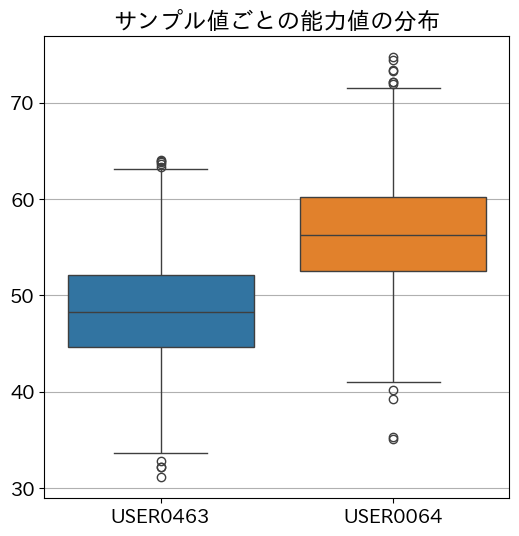

In [21]:
# USER0463とUSER0064の能力値のサンプルデータを抽出
w1 = idata['posterior'].data_vars[
    'theta'].loc[:,:,['USER0463','USER0064']].values

# 軸の順番を入れ替え後、受験者を第一要素とする行列に変換
w2 = w1.transpose().reshape(2, -1)

# 能力値のスケール変更
w3 = (w2 - x1_mean)/x1_std * 10 + 50

# 受験者を列名とするデータフレームに変換
df_w3 = pd.DataFrame(w3.T, columns=['USER0463', 'USER0064'])

# Seabornのboxplot関数で可視化
sns.boxplot(df_w3)
plt.title('サンプル値ごとの能力値の分布');